# Trabajo 2 - 2021-2022

**Autor**: Sergio Rodríguez Calvo

Vamos a comenzar el experimento declarando todo aquellos que vamos a necesitar a lo largo del cuadernos.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Elección y análisis del conjunto de datos

El conjunto de datos ejegido es [_hepatitis_](https://archive.ics.uci.edu/ml/datasets/Hepatitis), que consiste en un conjunto multivariante con 19 atributos (categóricos, enteros y reales) y un valor de clasificación binaría: DIE que indica que el paciente muere; LIVE que indica que el paciente sobrevive. El conjunto de datos cuenta con un total de 155 instancias o ejemplos.

Los nombres de los atributos son los siguientes:

In [2]:
names = [   
            'class',
            'age',
            'sex',
            'steroid',
            'antivirals',
            'fatigue',
            'malaise',
            'anorexia',
            'liver_big',
            'liver_firm',
            'spleen_palpable',
            'spiders',
            'ascities',
            'varices',
            'bilirubin',
            'alk_phosphate',
            'sgot',
            'albumin',
            'protime',
            'histology'
        ]

Vamos a cargar el conjunto de datos en un _dataframe_ de Pandas.

In [3]:
missing_values = ['?']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data'
df = pd.read_csv(url, names=names, na_values=missing_values)
df_original = df.copy(deep=True)

Vamos a mostrar la información general proporcionada por el _dataframe_, donde podemos ver el número de entradas (ejemplos o instancias), los atributos, el tipo de dato de cada atributo y los valores presentes (no nulos), aunque luego mostraremos más información respecto de los valores ausentes.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   class            155 non-null    int64  
 1   age              155 non-null    int64  
 2   sex              155 non-null    int64  
 3   steroid          154 non-null    float64
 4   antivirals       155 non-null    int64  
 5   fatigue          154 non-null    float64
 6   malaise          154 non-null    float64
 7   anorexia         154 non-null    float64
 8   liver_big        145 non-null    float64
 9   liver_firm       144 non-null    float64
 10  spleen_palpable  150 non-null    float64
 11  spiders          150 non-null    float64
 12  ascities         150 non-null    float64
 13  varices          150 non-null    float64
 14  bilirubin        149 non-null    float64
 15  alk_phosphate    126 non-null    float64
 16  sgot             151 non-null    float64
 17  albumin         

Podemos ver también las primeras instancias del conjunto.

In [5]:
df.head()

,class,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascities,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology
0,2,30,2,1.0,2,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,85.0,18.0,4.0,NaN,1
1,2,50,1,1.0,2,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,0.9,135.0,42.0,3.5,NaN,1
2,2,78,1,2.0,2,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,96.0,32.0,4.0,NaN,1
3,2,31,1,NaN,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,46.0,52.0,4.0,80.0,1
4,2,34,1,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,200.0,4.0,NaN,1


## Preprocesado

Vamos a comenzar con el preprocesado, en concreto, cambiando los valores de clasificación 1 (DIE) y 2(LIVE) por 0 y 1 respectivamente, ya que es más conveniente de cara a realizar una clasificación binaria.

In [6]:
df["class"].replace((1,2),(0,1),inplace=True)

Ahora, vamos a ver la cantidad de valores ausentes por atributo. Ya hemos visto anterioremente cierta información al respecto cuando hemos ejecutado `df.info()`, pero vamos a ver la cantidad de atributos ausentes por atributo.

In [7]:
df.isnull().sum()

class               0
age                 0
sex                 0
steroid             1
antivirals          0
fatigue             1
malaise             1
anorexia            1
liver_big          10
liver_firm         11
spleen_palpable     5
spiders             5
ascities            5
varices             5
bilirubin           6
alk_phosphate      29
sgot                4
albumin            16
protime            67
histology           0
dtype: int64

Otro aspecto importante es conocer si el conjunto de datos está balanceado.

In [8]:
df['class'].value_counts()

1    123
0     32
Name: class, dtype: int64

Vemos que no está balanceado, ya que tenemos 32 ejemplos clasificados como DIE (o 0) y 123 ejemplos clasificados como LIVE (o 1). A la hora de evluar diferentes modelos, debemos tener en cuenta que los datos no están balanceados respecto de su clasificación.

La primera transformación que vamos a realizar es la relativa al atributo edad. Vamos a agrupar los ejemplos por rangos de edad, sin ejecutar One-Hot para evitar la correlación, ya que en este caso es preferible dejar los rangos como una especie de categorías numéricas, para así mantener la correlación.

In [9]:
df['age'] = pd.cut(x=df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80],labels=[1,2,3,4,5,6,7,8])

La segunda transformación es la relativa al campo de tipo categórico sexo, al que vamos a realizar una transformación de valores tales como, 1 para 'male' y 2 para 'female'. Posteriormente, realizamos un One-Hot adjuntando el resultado al _dataframe_ y eliminando el campo que teníamos anteriormente.

In [10]:
sex_df = pd.get_dummies(df.sex, prefix='sex')
df = pd.concat([df, sex_df], axis=1)
df.rename(columns={"sex_1": "sex_male", "sex_2": "sex_female"}, inplace=True)
df.drop(['sex'], axis=1, inplace=True)

La siguiente transformación va a ser transformar todos los atributos categóricos que vienen representados como 1 (para NO) y 2 (para SÍ), en 0 y 1 respectivamente.

In [11]:
df['steroid'].replace((1,2),(0,1),inplace=True)
df['antivirals'].replace((1,2),(0.,1.),inplace=True)
df['fatigue'].replace((1,2),(0,1),inplace=True)
df['malaise'].replace((1,2),(0,1),inplace=True)
df['anorexia'].replace((1,2),(0,1),inplace=True)
df['liver_big'].replace((1,2),(0,1),inplace=True)
df['liver_firm'].replace((1,2),(0,1),inplace=True)
df['spleen_palpable'].replace((1,2),(0,1),inplace=True)
df['spiders'].replace((1,2),(0,1),inplace=True)
df['ascities'].replace((1,2),(0,1),inplace=True)
df['varices'].replace((1,2),(0,1),inplace=True)
df['histology'].replace((1,2),(0.,1.),inplace=True)

A continuación, vamos a corregir los valores ausentes.

Los atributos de tipo categórico ausentes, van a ser reemplazados por la moda.

In [12]:
df['steroid'].fillna(df['steroid'].mode()[0], inplace=True)
df['fatigue'].fillna(df['fatigue'].mode()[0], inplace=True)
df['malaise'].fillna(df['malaise'].mode()[0], inplace=True)
df['anorexia'].fillna(df['anorexia'].mode()[0], inplace=True)
df['liver_big'].fillna(df['liver_big'].mode()[0], inplace=True)
df['liver_firm'].fillna(df['liver_firm'].mode()[0], inplace=True)
df['spleen_palpable'].fillna(df['spleen_palpable'].mode()[0], inplace=True)
df['spiders'].fillna(df['spiders'].mode()[0], inplace=True)
df['ascities'].fillna(df['ascities'].mode()[0], inplace=True)
df['varices'].fillna(df['varices'].mode()[0], inplace=True)

Para los atributos de tipo numérico ausentes, vamos a probar con dos opciones: la media y la mediana.

Vamos a definir una función que nos transforma un _dataframe_ de Pandas en un _array_ de Numpy, ya que la vamos a necesitar a lo largo de todo el experimento.

In [13]:
def from_df_to_X_y(df):
    X = df.to_numpy()[:,1:]
    y = df.to_numpy()[:,0]

    return X,y

Lo primero que vamos a hacer es probar con una versión del _dataframe_ en el que sustituimos los valores ausentes por la media.

In [14]:
df_mean = df.copy(deep=True)
df_mean['bilirubin'].fillna(df_mean['bilirubin'].mean(), inplace=True)
df_mean['alk_phosphate'].fillna(df_mean['alk_phosphate'].mean(), inplace=True)
df_mean['sgot'].fillna(df_mean['sgot'].mean(), inplace=True)
df_mean['albumin'].fillna(df_mean['albumin'].mean(), inplace=True)
df_mean['protime'].fillna(df_mean['protime'].mean(), inplace=True)

Vamos a evaluar este caso utilizando un modelo de regresión logística.

In [15]:
X, y = from_df_to_X_y(df_mean)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3)

lr_mean = LogisticRegression(random_state=10 ,solver='lbfgs').fit(X_train, y_train)
score = lr_mean.score(X_test,y_test)

print('El rendimiento es {:.3f}'.format(score))

El rendimiento es 0.809


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Repetimos el proceso pero utilizando esta vez la mediana.

In [16]:
df_median = df.copy(deep=True)
df_median['bilirubin'].fillna(df_median['bilirubin'].median(), inplace=True)
df_median['alk_phosphate'].fillna(df_median['alk_phosphate'].median(), inplace=True)
df_median['sgot'].fillna(df_median['sgot'].median(), inplace=True)
df_median['albumin'].fillna(df_median['albumin'].median(), inplace=True)
df_median['protime'].fillna(df_median['protime'].median(), inplace=True)

In [17]:
X, y = from_df_to_X_y(df_median)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3)

lr_median = LogisticRegression(random_state=10 ,solver='lbfgs').fit(X_train, y_train)
score = lr_median.score(X_test,y_test)

print('El rendimiento es {:.3f}'.format(score))

El rendimiento es 0.894


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


El modelo con el que mejor resultado hemos obtenido es mediante la media, por lo que vamos a utilizar dicha transformacion para reemplazar los valores ausentes.

In [18]:
df['bilirubin'].fillna(df['bilirubin'].mean(), inplace=True)
df['alk_phosphate'].fillna(df['alk_phosphate'].mean(), inplace=True)
df['sgot'].fillna(df['sgot'].mean(), inplace=True)
df['albumin'].fillna(df['albumin'].mean(), inplace=True)
df['protime'].fillna(df['protime'].mean(), inplace=True)

Una vez realizadas todo el preprocesamiento, vamos a echar un vistazo tanto a las primeras instancias del conjunto, así como comprobar que efectivamente ya no quedan más valores nulos en el _dataframe_.

In [19]:
df.head()

,class,age,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,...,ascities,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,sex_male,sex_female
0,1,3,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,85.000000,18.0,4.0,61.852273,0.0,0,1
1,1,5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.9,135.000000,42.0,3.5,61.852273,0.0,1,0
2,1,8,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.7,96.000000,32.0,4.0,61.852273,0.0,1,0
3,1,4,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.7,46.000000,52.0,4.0,80.000000,0.0,1,0
4,1,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,105.325397,200.0,4.0,61.852273,0.0,1,0


In [20]:
df.isnull().sum()

class              0
age                0
steroid            0
antivirals         0
fatigue            0
malaise            0
anorexia           0
liver_big          0
liver_firm         0
spleen_palpable    0
spiders            0
ascities           0
varices            0
bilirubin          0
alk_phosphate      0
sgot               0
albumin            0
protime            0
histology          0
sex_male           0
sex_female         0
dtype: int64

## Selección de atributos

Vamos a comenzar la selección de atributos para obtener un conjunto de datos con menos atributos, lo que mejorará el rendimiento de los modelos, mostrando una representación gráfica conjunta de las instancias según su clasificación. Esta es una forma visual de ver si los conjuntos presentan una clara diferenciación según su clasificación.

Vamos a seleccionar sólo los atributos numéricos, ya que de otra forma no vamos a obtener una imagen del tamaño adecuado con los 20 atributos.

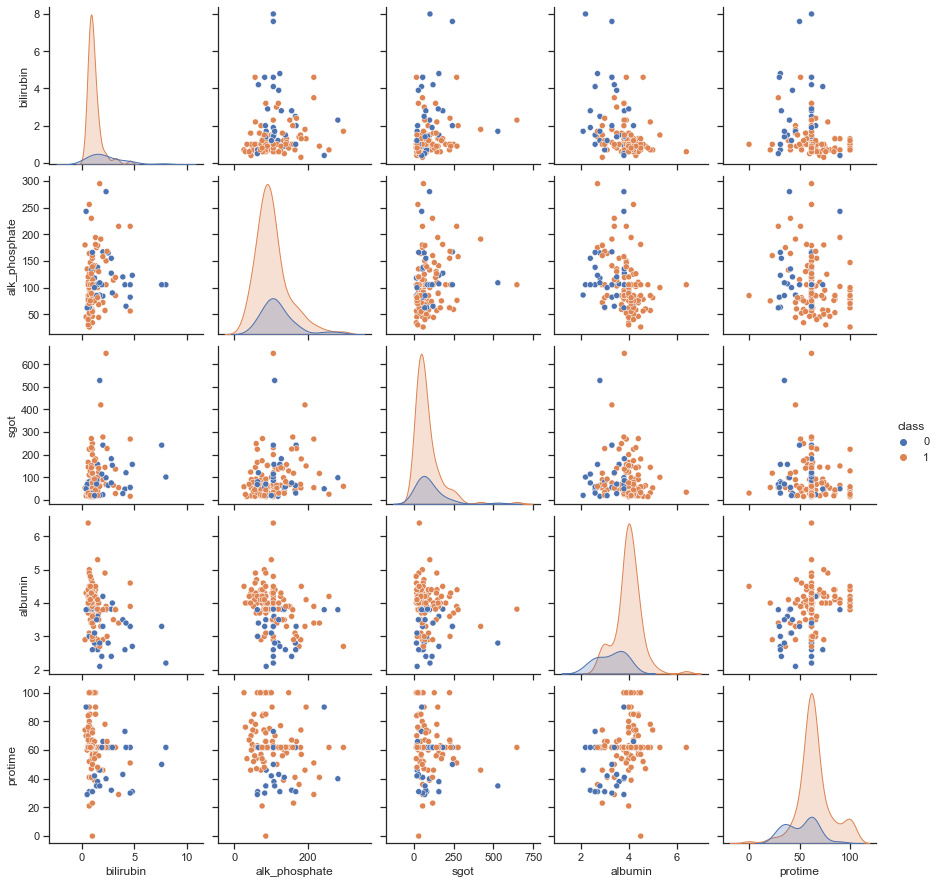

In [21]:
selected = ['class','bilirubin','alk_phosphate','sgot','albumin','protime']
sns.pairplot(df[selected], hue='class')

Además, de estos mismos atributos, vamos a estudiar la correlación que hay entre ellos.

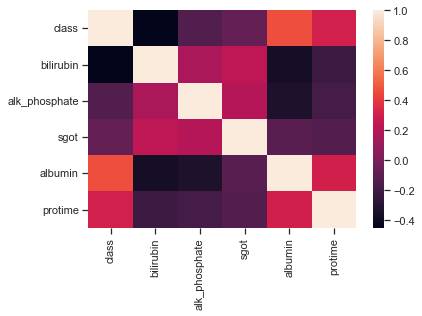

In [22]:
def correlation_heatmap(corr):
    ax = sns.heatmap(corr)

num_corr = df[selected].corr()
correlation_heatmap(num_corr)

Vemos en la leyenda que el color más blanco (más cercano a un valor 1) que significa que los atributos están correlados, de forma que cuando uno crece el otro también crece. El color negro (más cercano a -1) también significa correlación, pero por el contrario cuando un atributo crece el otro decrece. Con un color morado (más cercano a 0), sabemos que los atributos no están correlados.

Por tanto, vemos que el atributo `bilirubin` está correlado con el valor de clasificación de forma descendente o, por el contrario, vemos que `alk_phosphate` y `sgot` no están correlados con el valor de clasificación.

### Análisis de componentes principales

Vamos a realizar un análisis de componentes principales (PCA) para estudiar como contribuyen cada uno de los atributos en la variabilidad de los datos. Buscamos reducir el número de atributos del conjunto de datos seleccionando aquellos que nos van a permitir realizar predicciones pero manteniendo/mejorando el rendimiento de los modelos.

In [23]:
def plot_explained_variance(pca, cumm=False):
    data = pca.explained_variance_ratio_
    if cumm:
        data = np.cumsum(data)
    sns.lineplot(data=data, marker='o', color='k')
    plt.xlabel('Principal component')
    plt.ylabel('Explained variance ratio')

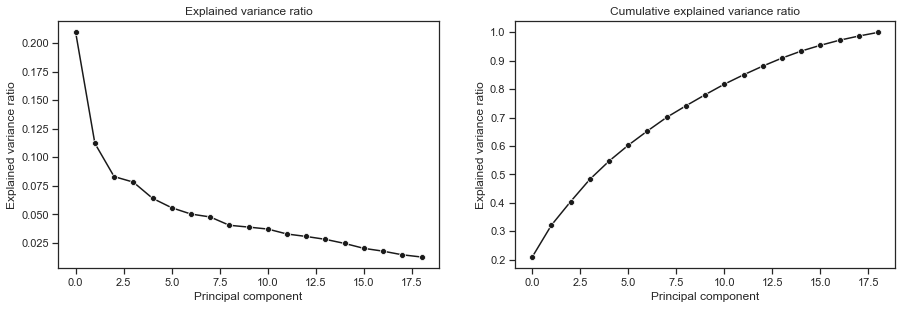

In [24]:
X_data, y_data = from_df_to_X_y(df)
Xt_data = StandardScaler().fit_transform(X_data)

n_components = Xt_data.shape[1] - 1
pca = PCA(n_components=n_components)
pca.fit_transform(Xt_data)
fig = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Explained variance ratio')
plot_explained_variance(pca)
plt.subplot(2,2,2)
plt.title('Cumulative explained variance ratio')
plot_explained_variance(pca, cumm=True)

En la gráfica anterior, vemos como contribuye cada componente principal respecto de la varianza (izquierda) y, en una vista acumulativa (derecha), vemos con cuantas compoentes principales explicamos la varianza de los datos.

De lo anterior, deducimos que con aproximadamente 13 compoentes explicamos el 90% de la varianza. El umbral puede depender, desde el 70% hasta un 90%, según nos interese. Algunos autores recomiendan seleccionar justo donde se alcance `0.7` de ratio de varianza.

En cualquier caso, vamos a probar a realizar una PCA con diferentes número de componentes, comenzando por los 20 componentes iniciales. Para ello, vamos a definir una función que nos va a permitir realizar este proceso, donde vamos a usar un modelo de regresión logistica para medir el rendimeinto.

**Nota**: PCA trabaja mejor con los datos estandarizados.

In [25]:
def pca(X, y, n_components=4):
    Xt = StandardScaler().fit_transform(X)

    pca = PCA(n_components=n_components)
    pca.fit(Xt)
    X_pca = pca.transform(Xt)

    lr = LogisticRegression(random_state=10, solver='lbfgs').fit(X_pca, y)
    score = lr.score(X_pca,y)

    return score, pca.explained_variance_

In [26]:
score_pca_20, exp_var_pca_20 = pca(X_data, y_data, 20)
print('El rendimiento es {:.3f}'.format(score_pca_20))
print('La importancia de cada componente es:',exp_var_pca_20)

El rendimiento es 0.890
La importancia de cada componente es: [4.21232178e+00 2.25789869e+00 1.67346081e+00 1.57611286e+00
 1.29128900e+00 1.12433551e+00 1.01384332e+00 9.62463536e-01
 8.16041488e-01 7.84123474e-01 7.49392427e-01 6.62320488e-01
 6.18843314e-01 5.68082664e-01 4.96192937e-01 4.09620083e-01
 3.60186109e-01 2.96251744e-01 2.57089882e-01 7.30525968e-32]


In [27]:
score_pca_19, exp_var_pca_19 = pca(X_data, y_data, 19)
print('El rendimiento es {:.3f}'.format(score_pca_19))
print('La importancia de cada componente es:',exp_var_pca_19)

El rendimiento es 0.890
La importancia de cada componente es: [4.21232178 2.25789869 1.67346081 1.57611286 1.291289   1.12433551
 1.01384332 0.96246354 0.81604149 0.78412347 0.74939243 0.66232049
 0.61884331 0.56808266 0.49619294 0.40962008 0.36018611 0.29625174
 0.25708988]


In [28]:
score_pca_13, exp_var_pca_13 = pca(X_data, y_data, 13)
print('El rendimiento es {:.3f}'.format(score_pca_13))
print('La importancia de cada componente es:',exp_var_pca_13)

El rendimiento es 0.890
La importancia de cada componente es: [4.21232178 2.25789869 1.67346081 1.57611286 1.291289   1.12433551
 1.01384332 0.96246354 0.81604149 0.78412347 0.74939243 0.66232049
 0.61884331]


In [29]:
score_pca_10, exp_var_pca_10 = pca(X_data, y_data, 10)
print('El rendimiento es {:.3f}'.format(score_pca_10))
print('La importancia de cada componente es:',exp_var_pca_10)

El rendimiento es 0.897
La importancia de cada componente es: [4.21232178 2.25789869 1.67346081 1.57611286 1.291289   1.12433551
 1.01384332 0.96246354 0.81604149 0.78412347]


In [30]:
score_pca_5, exp_var_pca_5 = pca(X_data, y_data, 5)
print('El rendimiento es {:.3f}'.format(score_pca_5))
print('La importancia de cada componente es:',exp_var_pca_5)

El rendimiento es 0.897
La importancia de cada componente es: [4.21232178 2.25789869 1.67346081 1.57611286 1.291289  ]


In [32]:
score_pca_1, exp_var_pca_1 = pca(X_data, y_data, 1)
print('El rendimiento es {:.3f}'.format(score_pca_1))
print('La importancia de cada componente es:',exp_var_pca_1)

El rendimiento es 0.858
La importancia de cada componente es: [4.21232178]


TODO: ver la PCA con más detenimiento

In [31]:
"""
df['bilirubin'] = pd.cut(x=df['bilirubin'], bins=[0., .39, .8, 1.2, 2., 3., 4., 8.1],labels=[1,2,3,4,5,6,7])
df['alk_phosphate'] = pd.cut(x=df['alk_phosphate'], bins=[25, 33, 80, 120, 160, 200, 250, 296],labels=[1,2,3,4,5,6,7])
df['sgot'] = pd.cut(x=df['sgot'], bins=[13, 100, 200, 400, 500, 649],labels=[1,2,3,4,5])
df['albumin'] = pd.cut(x=df['albumin'], bins=[2.0, 3., 3.8, 4.5, 5., 6., 6.5],labels=[1,2,3,4,5,6])
df['protime'] = pd.cut(x=df['protime'], bins=[-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],labels=[1,2,3,4,5,6,7,8,9,10])
"""

"\ndf['bilirubin'] = pd.cut(x=df['bilirubin'], bins=[0., .39, .8, 1.2, 2., 3., 4., 8.1],labels=[1,2,3,4,5,6,7])\ndf['alk_phosphate'] = pd.cut(x=df['alk_phosphate'], bins=[25, 33, 80, 120, 160, 200, 250, 296],labels=[1,2,3,4,5,6,7])\ndf['sgot'] = pd.cut(x=df['sgot'], bins=[13, 100, 200, 400, 500, 649],labels=[1,2,3,4,5])\ndf['albumin'] = pd.cut(x=df['albumin'], bins=[2.0, 3., 3.8, 4.5, 5., 6., 6.5],labels=[1,2,3,4,5,6])\ndf['protime'] = pd.cut(x=df['protime'], bins=[-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],labels=[1,2,3,4,5,6,7,8,9,10])\n"

# Evaluación de modelos